# Constructing dense offset maps from Sentinel-1 A/B SLC Bursts using topsApp and autoRIFT

**Authors**: Bryan Riel, Forrest Williams, Franz Meyer

In this notebook, we will explore how to generate dense offset maps (feature tracking) from co-registered Sentinel-1 Burst SLCs within the `topsApp` processing chain. As before, after obtaining the appropriate Burst SLC data, we will prepare a DEM for our study area, and download the necessary orbit and aux files from ASF/ESA (see previous tutorials on processing in TOPS mode with `topsApp.py`).

## Comparison of dense offsets vs. InSAR phase

Dense offsets maps are useful in situations where ground or surface displacement is large between two acquisition dates. In these cases, reference and secondary SLCs can not be precisely aligned, and we would get complete decoherence in the interferometric phase. Such situations are common in glaciology, certain geomorphology applications (e.g., landslides), and for very large earthquakes. Additionally, dense offsets automatically give us displacement in two directions (range and azimuth), whereas InSAR will only provide phase changes in the range direction. Thus, the range offsets measure motion in the radar line-of-sight direction, whereas the azimuth offsets measure horizontal motion in the radar flight direciton (along-track). 

Of course, the main disadvantage of offset maps is the much higher level of noise in the cross-correlation measurements as compared to InSAR phase. For example, the figure below compares InSAR phase and range pixel offsets for the 2021 M7.2 Haiti earthquake (obtained from Eric Fielding Twitter https://twitter.com/EricFielding/status/1428629519947034624):

<img src="support_files/HaitiOffsets.png" width=900/>

Note, this comparison is only valid if the InSAR phase is not decorrelated. In general, offsets will provide a more robust, albeit noisier, estimate of surface displacment. Another disadvantage is that dense offset map generation takes considerably more compute power as compared to interferogram formation, but ISCE does provide GPU implementations of dense offsets to significantly reduce computation time.

## Study area and setup

The Malaspina Glacier is a prominent example of a piedmont glacier, distinguished by its expansive flow dynamics and unique geometry. Spanning approximately 3,900 square kilometers (1,500 square miles), it forms from the convergence of multiple valley glaciers descending from the Saint Elias Mountains. Unlike typical valley glaciers constrained by narrow paths, the Malaspina spreads out widely over a coastal plain as it approaches the Gulf of Alaska, creating a broad, lobe-like shape. This spreading is facilitated by its immense ice volume and relatively gentle slope, allowing the glacier to flow laterally as well as forward. The glacier's flow dynamics are complex, involving interactions between ice movement, sediment transport, and surface melting. The presence of moraines and ice-cored hills indicates significant sediment deposition and ice deformation. These features provide valuable insights into the glacier's history and the processes shaping its evolution.

<img style="padding: 10px 10px 10px 10px" src="Figs/Malaspina-Hubbard.jpg" width="750" align="center" />

## `topsApp` and Burst SLC products

In this notebook, we will utilize the newly-released Burst SLC products by ASF.

https://asf.alaska.edu/datasets/daac/sentinel-1-bursts/

"ASF offers derived burst-based products for Sentinel-1 single look complex (SLC) data collected via the Interferometric Wide (IW) mode and Extra-Wide Swath (EW) modes*. These products are particularly useful for scientists interested in obtaining data for small geographic areas and workflows requiring precise alignment of co-geolocated SLC data through time (i.e., time series analyses)..."

"...While data from many bursts are packaged together in the standard SLC products, SLC data from a single burst can be utilized independently. To enable single-burst applications, ASF has developed an extraction service that allows users to download single-burst IW and EW SLC products. The burst SLC data are available as a GeoTIFF and supplemental metadata files from the parent SLC product are available as a single XML file."

<img src="Figs/burst_frames.png" width=700/>

Let's first import necessary Python packages.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import datetime
import glob
import sys
import os
from osgeo import gdal, osr
gdal.UseExceptions()
import scipy.ndimage as ndimage
import isce

# Some utility functions for plotting and loading data
%aimport utilities
utils = utilities

# autoRIFT and Geogrid
%aimport testGeogrid_ISCE
%aimport testautoRIFT_ISCE
loadMetadata = testGeogrid_ISCE.loadMetadata
runGeogrid = testGeogrid_ISCE.runGeogrid
generateAutoriftProduct = testautoRIFT_ISCE.generateAutoriftProduct
    
DEFAULT_PARAMETER_FILE = '/vsicurl/http://its-live-data.s3.amazonaws.com/' \
                         'autorift_parameters/v001/autorift_landice_0120m.shp'

os.environ['OMP_NUM_THREADS'] = '8'
plt.rc('font', size=13)
parent_dir = os.getcwd()

The burst SLCs can be downloaded from Vertex or with the ASF API. The `burst2safe` package (https://github.com/forrestfwilliams/burst2safe) provides a convenient way to automatically download burst SLCs and convert them to an equivalent ESA SAFE file that can be processed with ISCE just like a normal Sentinel-1 SLC. In this lab, we have already run the `burst2stack` command for the Malaspina glacier, which allows us to automatically query bursts for a given region, relative orbit, and date range. An example call to `burst2stack` looks like:

```
> burst2stack --rel-orbit 50 --start-date 2020-05-09 --end-date 2020-05-25 --pols VV --min-bursts 2 --output-dir safe --extent -140.8291 59.9193 -140.1692 60.3013
Creating SAFEs for 2 time periods...

Using burst group search...
Found 3 burst(s).
Check burst group validity...
Downloading data...
Download complete.
Creating SAFE...
SAFE created!

Using burst group search...
Found 3 burst(s).
Check burst group validity...
Downloading data...
Download complete.
Creating SAFE...
SAFE created!
```

In our case, we have pre-downloaded three burst for two different dates. To unpack the burst data, as well as orbits, DEMS, and auxiliary data, run the following commands:

In [ ]:
!aws --region=us-west-2 --no-sign-request s3 cp s3://asf-jupyter-data-west/malaspina_bursts.tar.gz malaspina_bursts.tar.gz

In [3]:
!tar -xvzf malaspina_bursts.tar.gz

safe/
safe/S1A_IW_SLC__1SSV_20200510T025515_20200510T025521_032497_03C36B_A924.SAFE/
safe/S1A_IW_SLC__1SSV_20200522T025516_20200522T025522_032672_03C8B8_64C9.SAFE/
safe/S1A_IW_SLC__1SSV_20200522T025516_20200522T025522_032672_03C8B8_64C9.SAFE/manifest.safe
safe/S1A_IW_SLC__1SSV_20200522T025516_20200522T025522_032672_03C8B8_64C9.SAFE/measurement/
safe/S1A_IW_SLC__1SSV_20200522T025516_20200522T025522_032672_03C8B8_64C9.SAFE/annotation/
safe/S1A_IW_SLC__1SSV_20200522T025516_20200522T025522_032672_03C8B8_64C9.SAFE/support/
safe/S1A_IW_SLC__1SSV_20200522T025516_20200522T025522_032672_03C8B8_64C9.SAFE/support/s1-level-1-calibration.xsd
safe/S1A_IW_SLC__1SSV_20200522T025516_20200522T025522_032672_03C8B8_64C9.SAFE/support/s1-level-1-measurement.xsd
safe/S1A_IW_SLC__1SSV_20200522T025516_20200522T025522_032672_03C8B8_64C9.SAFE/support/s1-object-types.xsd
safe/S1A_IW_SLC__1SSV_20200522T025516_20200522T025522_032672_03C8B8_64C9.SAFE/support/s1-level-1-noise.xsd
safe/S1A_IW_SLC__1SSV_20200522T025516

After extraction, we can see that the burst data are in the `safe` directory. Additionally, we have several NASADEM DEMs, as well as orbit and auxiliary directories.

### Configuring topsApp

Our `topsApp` configuration in the file `topsApp.xml` contains the following:

```xml
<?xml version="1.0" encoding="UTF-8"?>
<topsApp>
  <component name="topsinsar">
    <property name="Sensor name">SENTINEL1</property>

    <component name="reference">
      <property name="orbit directory">orbits</property>
      <property name="auxiliary data directory">aux</property>
      <property name="output directory">reference</property>
      <property name="safe">safe/S1A_IW_SLC__1SSV_20200510T025515_20200510T025521_032497_03C36B_A924.SAFE</property>
    </component>

    <component name="secondary">
      <property name="orbit directory">orbits</property>
      <property name="auxiliary data directory">aux</property>
      <property name="output directory">secondary</property>
      <property name="safe">safe/S1A_IW_SLC__1SSV_20200522T025516_20200522T025522_032672_03C8B8_64C9.SAFE</property>
    </component> 

    <property name="range looks">7</property>
    <property name="azimuth looks">3</property>
    <property name="demFilename">nasadem_wgs84.dem</property>
    <property name="region of interest">[59.919, 60.301, -140.829, -140.169]</property>

    <!-- For dense offsets, we can skip many of the refinement steps used for InSAR -->
    <property name="do interferogram">False</property>
    <property name="do ESD">False</property>
    <property name="do unwrap">False</property>

    <!-- Parameters for dense offsets -->
    <property name="do denseoffsets">True</property>
    <property name="Ampcor window width">128</property>
    <property name="Ampcor window height">64</property>
    <property name="Ampcor search window width">20</property>
    <property name="Ampcor search window height">10</property>
    <property name="Ampcor skip width">64</property>
    <property name="Ampcor skip height">32</property>

  </component>
</topsApp>
```

In short, we have configured `topsApp` to co-register the burst SLCs while skipping processing steps necessary for interferogram formation (e.g., ESD, ionospheric corrections, unwrapping, etc.). Also pay attention to the final block of parameters for the dense offset computation and compare them to the following illustration. 

<img src="support_files/offset_parameters.png" width=700>

Note that in the Sentinel-1 IW mode, the SLC pixel spacing is roughly 2.3 meters in range and 14.1 meters in azimuth. Therefore, one can design the window widths and heights in order to achieve roughly square pixels in geographical space. We'll explore the impact of these offset parameters in the sections below.

## Run `topsApp`

In [4]:
!topsApp.py --start=startup --end=preprocess

2024-08-03 12:17:49,638 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
Step processing
Running step startup
None
The currently supported sensors are:  ['SENTINEL1']
Dumping the application's pickle object _insar to file  PICKLE/startup
The remaining steps are (in order):  ['preprocess', 'computeBaselines', 'verifyDEM', 'topo', 'subsetoverlaps', 'coarseoffsets', 'coarseresamp', 'overlapifg', 'prepesd', 'esd', 'rangecoreg', 'fineoffsets', 'fineresamp', 'ion', 'burstifg', 'mergebursts', 'filter', 'unwrap', 'unwrap2stage', 'geocode', 'denseoffsets', 'filteroffsets', 'geocodeoffsets']
Running step preprocess
Input XML files:  ['safe/S1A_IW_SLC__1SSV_20200510T025515_20200510T025521_032497_03C36B_A924.SAFE/annotation/s1a-iw1-slc-vv-20200510t025515-20200510t025524-032497-03c36b-001.xml']
Input TIFF files:  ['safe/S1A_IW_SLC__1SSV_2

In [ ]:
!topsApp.py --start=computeBaselines --end=geocode

In [ ]:
!topsApp.py --start=denseoffsets --end=geocodeoffsets

## Overview on dense offsets

The basic mathematical operation underpinning dense offset creation is 2D cross-correlation, which is a generalization of cross-correlation/discrete convolution in 1D (Wikipedia: https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif)

<img src="support_files/convolution1d_wiki.gif" width=600>

For a given patch of a reference image, we extract a template patch from a secondary image (where the secondary image has been co-registered to the reference image), and we slide the template patch over the reference patch and compute the 2D cross-correlation at each sliding position. This operation creates a 2D "correlation surface", and the coordinate of the peak of that surface tells us the nominal displacement (offset) between the two patches. The schematic below illustrates this procedure

![Template matching schematic](support_files/ampcor_schematic.png)

In the above cartoon, we slid the template over the source image at 9 discrete locations (3x3 search), and the peak correlation is at index (1, 1). By repeating this procedure for a dense array of patches, we can create a dense offset map, e.g.:

<img src="support_files/ampcor_global.png" width=300 height=600/>

In ISCE and `topsApp.py`, 2D cross-correlation is performed on reference and secondary SLCs. The complex data are converted into magnitude images prior to cross-correlation, and the offset map parameters can be configured in the top-level `topsApp.xml` file. In addition to nominal offsets, ISCE provides estimates of correlation signal-to-noise ratio (SNR) and covariance, where the latter is estimated by computing the curvature of the correlation surface.

### 1D example

To explore the key parts of template matching, let's look at a 1D example. Here, we generate a synthetic signal, `x`, and create a shifted version, `y`, which will also contain some data noise. The shift includes both integer and fractional shifts.

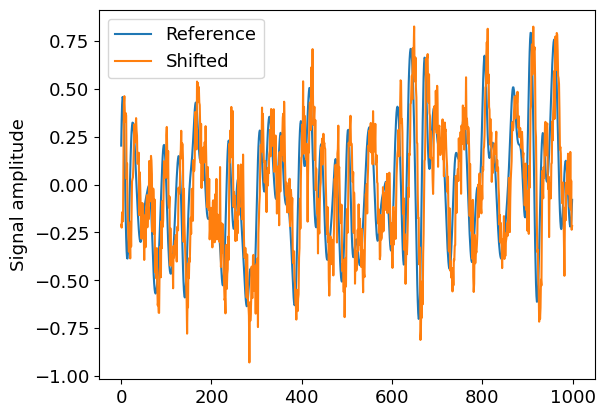

In [5]:
from scipy.signal import correlate, butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def apply_fractional_shift(signal, shift):
    n = len(signal)
    signal_fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(n)
    shift_fft = np.exp(-2j * np.pi * freq * shift)
    shifted_signal = np.real(np.fft.ifft(signal_fft * shift_fft))
    return shifted_signal

# Generate synthetic signals
def generate_signals(shift, noise_level, cutoff=0.05, fs=1.0, order=4, length=1000, pad=50, seed=0):
    # Generate white noise with padding
    x = np.random.randn(length + 2*pad)
    # Low-pass filter and remove padding
    x = lowpass_filter(x, cutoff, fs, order)[pad:-pad]
    # Apply shift and add noise
    rng = np.random.default_rng(seed)
    y = apply_fractional_shift(x, shift) + noise_level * rng.standard_normal(length)
    return x, y

# Generate reference and shifted signals
true_shift = 5.5
x, y = generate_signals(true_shift, 0.1)

plt.plot(x, label='Reference')
plt.plot(y, label='Shifted')
plt.ylabel('Signal amplitude')
plt.legend();

We now use `scipy.signal.correlate` to generate a 1D correlation "surface" (signal). The estimated integer shift is the location of the peak of the correlation signal.

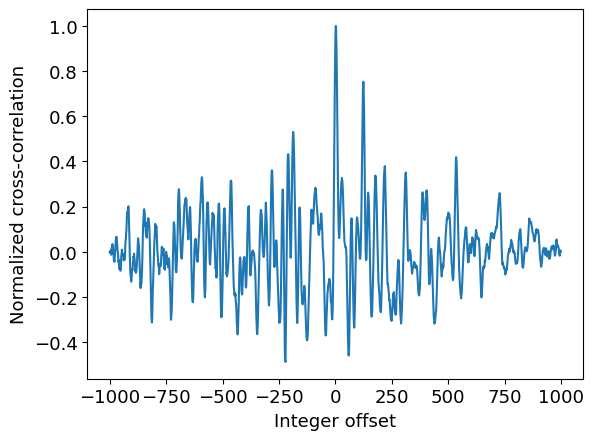

In [16]:
corr = correlate(y, x, mode='full')
peak_index = np.argmax(corr)
normalized_corr = corr / corr[peak_index]

c_index = np.arange(normalized_corr.size) - 1000
plt.plot(c_index, normalized_corr)
plt.xlabel('Integer offset')
plt.ylabel('Normalized cross-correlation');
#plt.xlim(-100, 100) # un-comment to zoom in on correlation peak

In order to estimate the fractional component of the offset, we will fit a 2nd-order polynomial function to a few points of the correlation signal near the peak. From the coefficients of the polynomial, we can then estimate the fractional offset. In this simple example, we will fit a polynomial using 3 points of the correlation surface centered on the peak:

In [9]:
def parabolic_interpolation(correlation, peak_index):
    vertex = 0.5 * (correlation[peak_index - 1] - correlation[peak_index + 1]) / (correlation[peak_index - 1] - 2 * correlation[peak_index] + correlation[peak_index + 1])
    return peak_index + vertex

# Estimate the fractional offset using the parabolic fit
frac_offset = parabolic_interpolation(normalized_corr, peak_index) - (len(x) - 1)
print('Estimated offset:', frac_offset)
print('True offset:', true_shift)

Estimated offset: 5.505341914844848
True offset: 5.5


Data noise can impact the estimate of the offset by lowering the signal-to-noise ratio (SNR) of the correlation signal peak. Lower SNR will lead to less-reliable offset measurements.

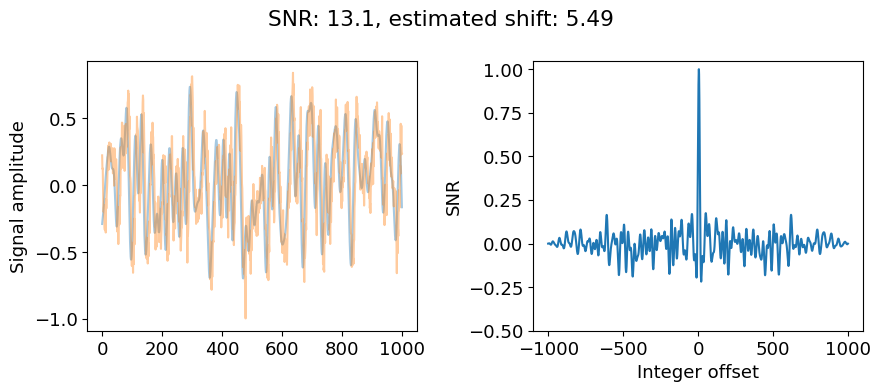

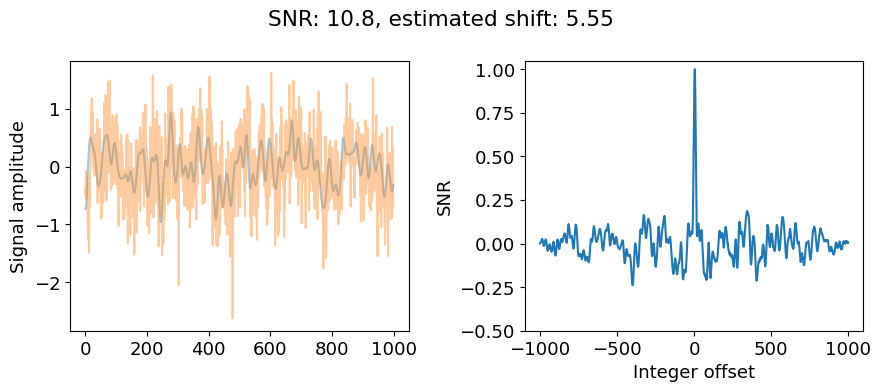

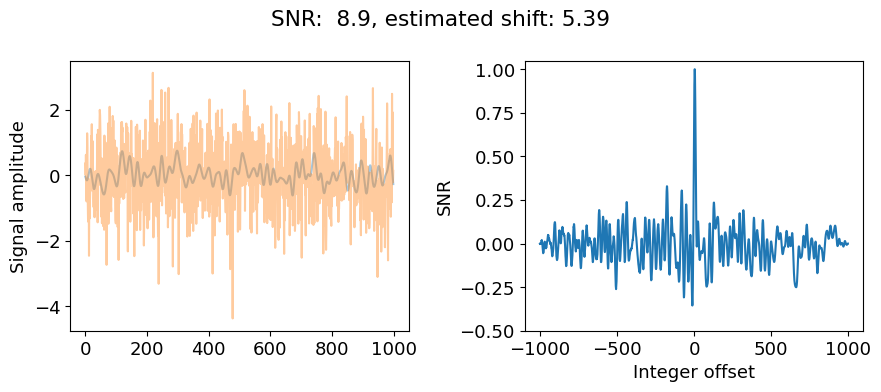

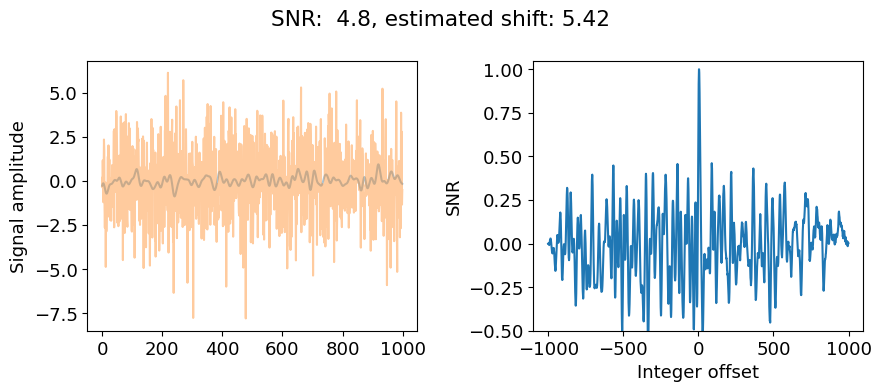

In [18]:
noise_levels = [0.1, 0.5, 1.0, 2.0]  # Different noise levels for SNR variation

# Perform simulations
errors = []
for noise_level in noise_levels:
    # Generate signals
    x, y = generate_signals(true_shift, noise_level)
    fig, axes = plt.subplot_mosaic('ab', figsize=(9, 4))
    axes['a'].plot(x, alpha=0.4)
    axes['a'].plot(y, alpha=0.4)
    axes['a'].set_ylabel('Signal amplitude')

    # Correlate
    corr = correlate(y, x, mode='full')
    peak_index = np.argmax(corr)
    normalized_corr = corr / corr[peak_index]
    c_index = np.arange(normalized_corr.size) - 1000
    axes['b'].plot(c_index, normalized_corr)
    axes['b'].set_ylim(-0.5, 1.05)
    axes['b'].set_ylabel('SNR')
    axes['b'].set_xlabel('Integer offset')

    # Compute SNR and estimate shift
    noise_index = np.setxor1d(peak_index, np.arange(x.size))
    snr = corr[peak_index] / np.std(corr[noise_index])
    estimated_shift = parabolic_interpolation(corr, peak_index) - (len(x) - 1)
    fig.suptitle(f'SNR: {snr:4.1f}, estimated shift: {estimated_shift:4.2f}')
    fig.set_tight_layout(True)

Additionally, the length of the signal (which is equivalent to the window length in our examples) can significantly impact the offset estimate. Shorter signal lengths lead to noisier correlation surfaces and more errors in the offset estimate. However, in practice, longer signal lengths are not always better. If there is significant non-affine warping of the signal `y` relative to `x`, then a longer signal length would be more contaminated by this warping and would lead to inaccurate offset estimates. 

### 2D example

Now let's explore the cross-correlation procedure in 2D by extracting a sample patch from the reference and secondary SLCs. Note, in the code below, we extract patches from pre-computed, multi-looked amplitude images.

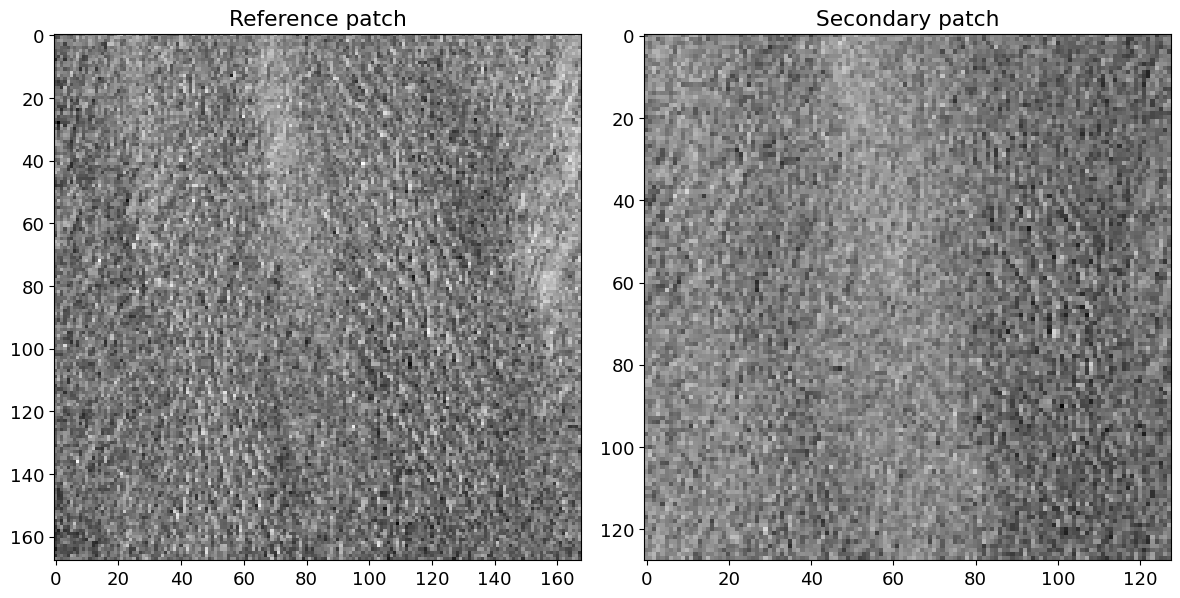

In [19]:
# Load 128x128 secondary (template patch)
sec_patch = np.load(os.path.join(parent_dir, 'support_files', 'sec_patch.npy'))
win_size = sec_patch.shape[0]

# Load 128x128 reference patch, which also includes a 20 pixel buffer for the search window
ref_patch = np.load(os.path.join(parent_dir, 'support_files', 'ref_patch.npy'))
search_win = (ref_patch.shape[0] - win_size) // 2

# Remove mean value from patches
ref_patch -= np.mean(ref_patch)
sec_patch -= np.mean(sec_patch)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
im1 = ax1.imshow(ref_patch, cmap='gray')
im2 = ax2.imshow(sec_patch, cmap='gray')
im2.set_clim(im1.get_clim())
ax1.set_title('Reference patch')
ax2.set_title('Secondary patch')
fig.set_tight_layout(True)

To perform the cross-correlation operation, we will use the match template function implemented in the OpenCV package (https://docs.opencv.org/4.5.2/d4/dc6/tutorial_py_template_matching.html) which outputs a correlation surface between a reference and template patch. This function is used as the core algorithm for autoRIFT. ISCE implements a similar version with additional machinery specifically for SLC images with varying frequency content.

Integer shifts: 0 3


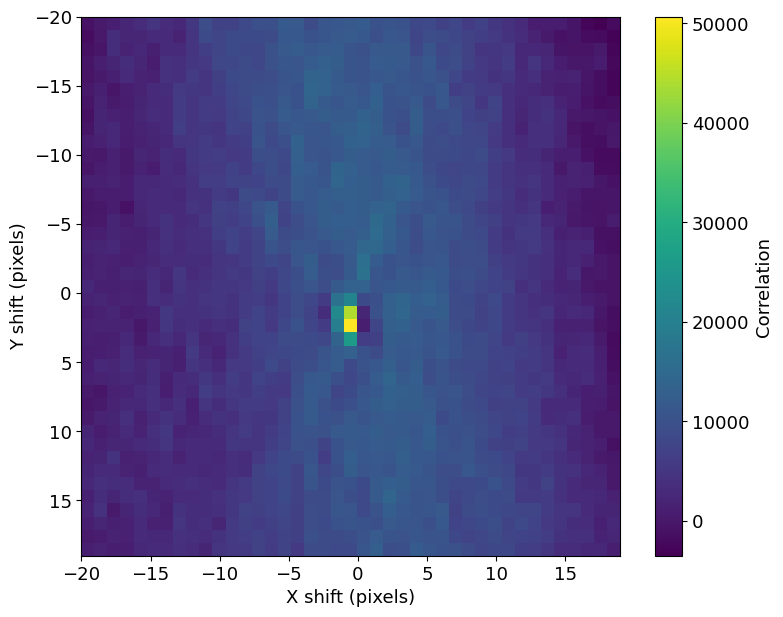

In [20]:
import cv2 as cv

# Call OpenCV template matching to get a correlation surface
correlation = cv.matchTemplate(ref_patch.astype(np.float32),
                               sec_patch.astype(np.float32),
                               cv.TM_CCOEFF)

# Construct arrays corresponding to the offset values
xoff = np.arange(-search_win, search_win, 1)
yoff = np.arange(-search_win, search_win, 1)

# Find the integer offset
indmax = np.argmax(correlation)
row_max, col_max = np.unravel_index(indmax, correlation.shape)

# Get the corresponding shift
max_xoffset = xoff[col_max]
max_yoffset = yoff[row_max]
print('Integer shifts:', max_xoffset, max_yoffset)

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(correlation, extent=[xoff[0], xoff[-1], yoff[-1], yoff[0]])
cbar = plt.colorbar(im, ax=ax, orientation='vertical')
cbar.set_label('Correlation')
ax.set_xlabel('X shift (pixels)');
ax.set_ylabel('Y shift (pixels)');

From the correlation surface, we can see a fairly concentrated peak at a coordinate of $\Delta X$ = 0 pixels and $\Delta Y$ = 3 pixels, which indicates most of the shift is in the azimuth direction. Now, we will extract a small sub-window around the correlation peak and oversample it in order to estimate the fractional offset.

Coarse integer X offset: 0
Coarse integer Y offset: 3
Sub-pixel X offset: -0.1968503937007875
Sub-pixel Y offset: 2.637795275590551


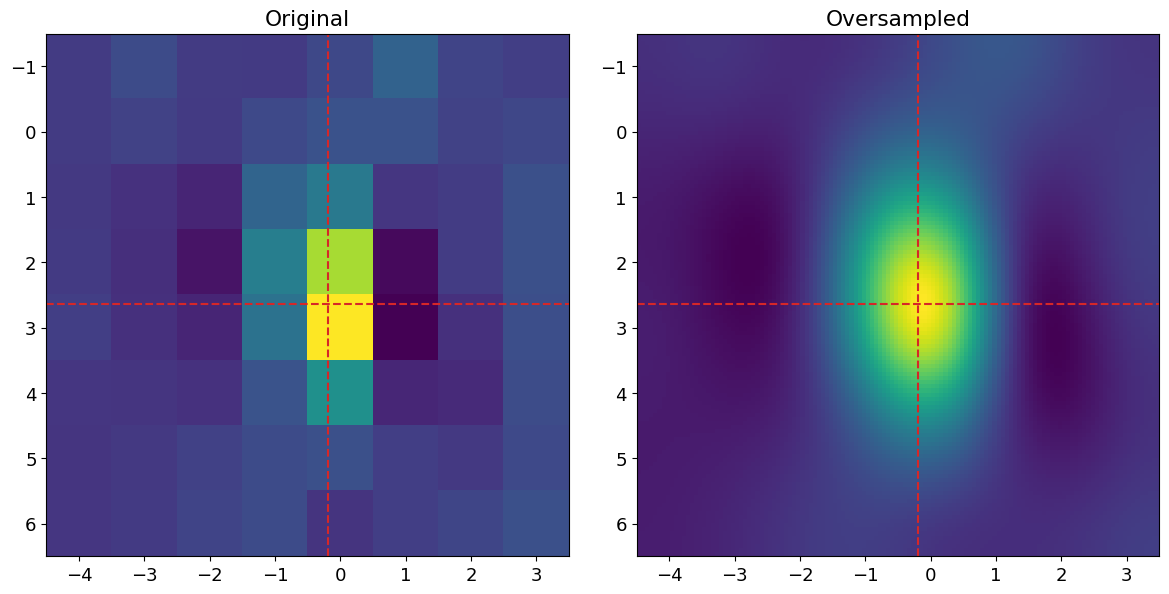

In [13]:
# Index of the peak
peak_index = np.argmax(correlation)
peak_row, peak_col = np.unravel_index(peak_index, correlation.shape)
coarse_dx = peak_col - search_win
coarse_dy = peak_row - search_win
print('Coarse integer X offset:', coarse_dx)
print('Coarse integer Y offset:', coarse_dy)

# Slice a small window
zoom_window = 8
row_slice = slice(peak_row - zoom_window // 2, peak_row + zoom_window // 2)
col_slice = slice(peak_col - zoom_window // 2, peak_col + zoom_window // 2)
correlation_subset = correlation[row_slice, col_slice]

# Call zoom function
zoom_factor = 16
correlation_zoom = ndimage.zoom(correlation_subset, zoom=zoom_factor, prefilter=False, order=4)

# Compute the grid corresponding to the oversampled coordinates CENTERED on peak
# These are the normalized "sub-pixel" coordinates
x = np.linspace(-zoom_window // 2, zoom_window // 2 - 1, zoom_factor * zoom_window)
y = np.linspace(-zoom_window // 2, zoom_window // 2 - 1, zoom_factor * zoom_window) # same as x
X, Y = np.meshgrid(x, y)

# Get index of peak oversampled correlation
peak_zoom_index = np.argmax(correlation_zoom)
peak_zoom_row, peak_zoom_col = np.unravel_index(peak_zoom_index, correlation_zoom.shape)

# Get the sub-pixel offsets
dx = X[peak_zoom_row, peak_zoom_col] + coarse_dx
dy = Y[peak_zoom_row, peak_zoom_col] + coarse_dy
print('Sub-pixel X offset:', dx)
print('Sub-pixel Y offset:', dy)

# Construct the image extent of the sub-window
half_zoom = zoom_window // 2
extent = np.array([-half_zoom + coarse_dx, half_zoom + coarse_dx,
                   half_zoom + coarse_dy, -half_zoom + coarse_dy]) - 0.5

# View the oversampled window next to the original
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

im1 = ax1.imshow(correlation_subset, extent=extent)
im2 = ax2.imshow(correlation_zoom, extent=extent)
# Plot location of sub-pixel peak
for ax in (ax1, ax2):
    ax.axvline(dx, ls='--', color='C3')
    ax.axhline(dy, ls='--', color='C3')

ax1.set_title('Original')
ax2.set_title('Oversampled')
fig.set_tight_layout(True)


After oversampling of the correlation surface by a factor 16, we now estimate $\Delta X$ = -0.20 pixels and $\Delta Y$ = 2.64 pixels. Note that the oversampling factor indicates that we can measure the pixel offsets to 1/16th of a pixel. However, this does __not__ mean that the accuracy of the measurement is 1/16th of a pixel. Recalling our 1D example above, the SNR and the the curvature of the correlation surface dictates the overall __uncertainty__ in the offset measurement. When the surface has a sharp peak, the uncertainty is lower. When the surface is more diffuse (spread out), the uncertainty is high. The ISCE dense offset module provides a measurement of this uncertainty via a covariance file `dense_ampcor_cov.bil`, which we will not discuss in this tutorial. Instead, we will utilize measurements of the SNR to mask out offsets with low SNR values.

## Visualize offsets

After the dense offset computation is completed, we can visualized the offsets by calling a helper function:

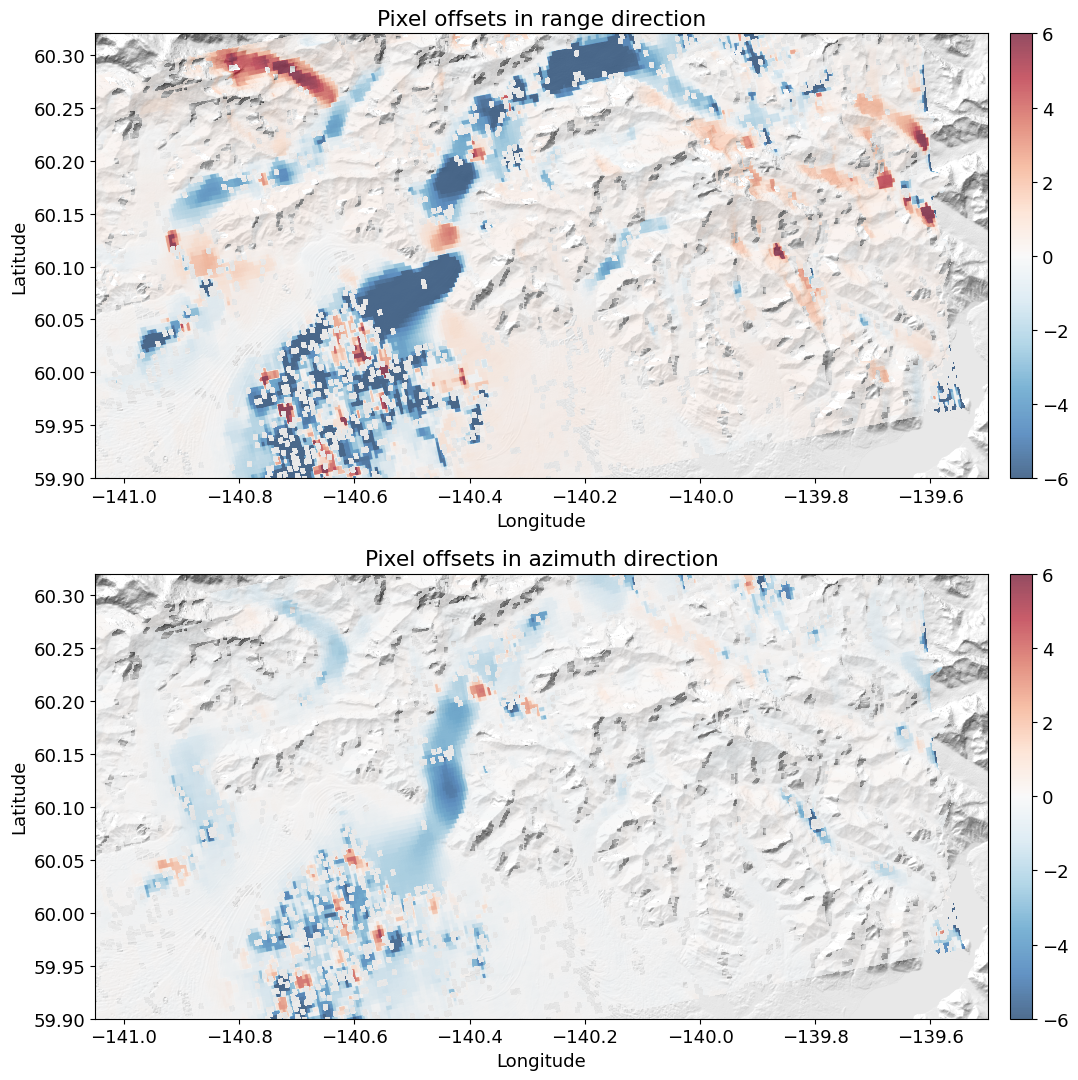

In [23]:
utils.plot_offsets(results_dir='merged', xlim=(-141.05, -139.5), ylim=(59.9, 60.32), snr_thresh=2)

## Generating offsets with autoRIFT

Alternatively to the dense offset computation included in the TOPS processing, we can make use of the `autoRIFT` package (https://github.com/nasa-jpl/autoRIFT), which is a more flexible, standalone package for finding pixel displacements between co-registered images of any format (including optical data). The basic offset computation algorithm is the same as the TOPS dense offsets (2D cross-correlation of image patches), but `autoRIFT` employs the `OpenCV` package to perform the cross-correlation. Moreover, `autoRIFT` allows you to provide land and ocean masks to limit search distances, as well as reference displacement rate maps to set search distances larger in fast moving areas and smaller in slow moving areas (e.g., on and off a fast-flowing glacier). These customizations can significantly reduce computational time compared to the standard dense offsets.

For Sentinel-1 radar data, `autoRIFT` is also packaged with the `Geogrid` module, which helps with transformations between radar and geographic coordinates. Both the `autoRIFT` and `Geogrid` modules are included in ISCE (e.g., `components.contrib.geo_autoRIFT.autoRIFT` and `components.contrib.geo_autoRIFT.geogrid`). For an example on using `autoRIFT` on optical images, see [this](https://github.com/parosen/Geo-SInC/blob/main/UNAVCO2022/4.3_Offset_stack_for_velocity_dynamics_with_autoRIFT/autorift.ipynb) notebook from Forrest Williams.

#### Implementation details

For this notebook, we will be calling functions included in the following Python files, which are included in the autoRIFT repository:
- `testGeogrid_ISCE.py`
- `testautoRIFT_ISCE.py`

### Running `Geogrid`

`Geogrid` is designed to compute transformations between pixels in image coordinates (e.g., range and azimuth in radar images, row and column for optical images) to pixels in an output map projection system. The output projection system is controlled by various input files passed into `Geogrid`, which specify spatially-varying parameters like window sizes, search window sizes, reference velocities, topography, and surface slopes __in map coordinates__.

For this tutorial, we will use a cropped version of the DEM used for TOPS processing which has also been warped to the UTM North projection (`cropped_nasadem_utm.tif`). We will then create the necessary input rasters for `Geogrid`. The function below implements the input raster generation.

In [24]:
def prepare_geogrid_inputs(demfile, srx=960, sry=960, csx=240, csy=240):
    """
    Generate the necessary input rasters for Geogrid.
    
    Parameters
    ----------
    demfile: str
        Name of input DEM.
    srx: float, optional
        Search window velocity (m/yr) in the map X-direction. Default: 960.
    sry: float, optional
        Search window velocity (m/yr) in the map Y-direction. Default: 960.
    csx: float, optional
        Window size (m) in the map X-direction. Default: 240.
    csy: float, optional
        Window size (m) in the map Y-direction. Default: 240.
    
    Returns
    -------
    None
    """
    # Load DEM elevation array in order to get shapes and geoTransform
    ds = gdal.Open(demfile, gdal.GA_ReadOnly)
    b = ds.GetRasterBand(1)
    h = b.ReadAsArray()
    geoTransform = ds.GetGeoTransform()
    shape = h.shape
    ds = None

    # Compute slopes
    dx = geoTransform[1]
    dy = geoTransform[-1]
    dhdx = np.gradient(h, dx, axis=1)
    dhdy = np.gradient(h, dy, axis=0)
    
    # DEM slopes
    utils.write_gdal('dhdx.tif', dhdx, geoTransform, dtype=gdal.GDT_Float32)
    utils.write_gdal('dhdy.tif', dhdy, geoTransform, dtype=gdal.GDT_Float32)
    
    # Write chip window size files
    utils.write_gdal('xMinChipSize.tif', csx * np.ones(shape, dtype=np.uint16), geoTransform, dtype=gdal.GDT_UInt16)
    utils.write_gdal('yMinChipSize.tif', csy * np.ones(shape, dtype=np.uint16), geoTransform, dtype=gdal.GDT_UInt16)
    utils.write_gdal('xMaxChipSize.tif', 4 * csx * np.ones(shape, dtype=np.uint16), geoTransform, dtype=gdal.GDT_UInt16)
    utils.write_gdal('yMaxChipSize.tif', 4 * csy * np.ones(shape, dtype=np.uint16), geoTransform, dtype=gdal.GDT_UInt16)
    
    # Write search ranges
    utils.write_gdal('vxSearchRange.tif', srx * np.ones(shape, dtype=np.int16), geoTransform, dtype=gdal.GDT_Int16)
    utils.write_gdal('vySearchRange.tif', sry * np.ones(shape, dtype=np.int16), geoTransform, dtype=gdal.GDT_Int16)
    
    # Write stable surface mask
    utils.write_gdal('StableSurface.tif', np.zeros(shape, dtype=np.uint8), geoTransform, dtype=gdal.GDT_Byte)
    
    # Write reference velocity field
    utils.write_gdal('vx.tif', np.zeros(shape, dtype=np.float32), geoTransform, dtype=gdal.GDT_Float32)
    utils.write_gdal('vy.tif', np.zeros(shape, dtype=np.float32), geoTransform, dtype=gdal.GDT_Float32)
    
os.chdir(parent_dir)
demfile = 'cropped_nasadem_utm.tif'
prepare_geogrid_inputs(demfile)

Once those files have been generated, we can run `Geogrid`:

In [25]:
# Set parameters for the pair we are processing
geogrid_info = {
    'dem':  demfile,
    'ssm': 'StableSurface.tif',
    'dhdx': 'dhdx.tif',
    'dhdy': 'dhdy.tif',
    'srx': 'vxSearchRange.tif',
    'sry': 'vySearchRange.tif',
    'csminx': 'xMinChipSize.tif',
    'csminy': 'yMinChipSize.tif',
    'csmaxx': 'xMaxChipSize.tif',
    'csmaxy': 'yMaxChipSize.tif',
    'vx': 'vx.tif',
    'vy': 'vy.tif'
}

# Load scene
meta_r = loadMetadata('reference')
meta_s = loadMetadata('secondary')

# Run Geogrid
geogrid_run_info = runGeogrid(
    meta_r,
    meta_s,
    epsg=32607,
    **geogrid_info
)
# Need to re-register all drivers
gdal.AllRegister()

Scene-center lat/lon: 60.115411003479224  -140.33165583308082


In [26]:
# Older versions of Geogrid (as used in this lab) do not create the file window_scale_factor.tif
# used in autoRIFT. We'll generate it manually here
ds = gdal.Open('window_offset.tif', gdal.GA_ReadOnly)
geoTransform = ds.GetGeoTransform()
ds = None
out = np.ones((geogrid_run_info['ycount'], geogrid_run_info['xcount']), dtype=np.float64)
utils.write_gdal('window_scale_factor.tif', [out, out], geoTransform, dtype=gdal.GDT_Float64)

The `Geogrid` outputs are the varioius `window_*tif` files:

In [27]:
!ls -l window_*.tif

-rw-r--r-- 1 jovyan users  5843137 Aug  3 12:34 window_chip_size_max.tif
-rw-r--r-- 1 jovyan users  5843137 Aug  3 12:34 window_chip_size_min.tif
-rw-r--r-- 1 jovyan users  5843137 Aug  3 12:34 window_location.tif
-rw-r--r-- 1 jovyan users  5843137 Aug  3 12:34 window_offset.tif
-rw-r--r-- 1 jovyan users 17518813 Aug  3 12:34 window_rdr_off2vel_x_vec.tif
-rw-r--r-- 1 jovyan users 17518813 Aug  3 12:34 window_rdr_off2vel_y_vec.tif
-rw-r--r-- 1 jovyan users 11680967 Aug  3 12:34 window_scale_factor.tif
-rw-r--r-- 1 jovyan users  5843137 Aug  3 12:34 window_search_range.tif
-rw-r--r-- 1 jovyan users  2921755 Aug  3 12:34 window_stable_surface_mask.tif


### Run `autoRIFT`

To run `autoRIFT`, we simply need to pass in the outputs from `Geogrid`:

In [28]:
# Construct dictionary of inputs to autoRIFT from the outputs of Geogrid
autorift_info = {
    'grid_location': 'window_location.tif',
    'init_offset': 'window_offset.tif',
    'search_range': 'window_search_range.tif',
    'chip_size_min': 'window_chip_size_min.tif',
    'chip_size_max': 'window_chip_size_max.tif',
    'stable_surface_mask': 'window_stable_surface_mask.tif',
    'offset2vx': 'window_rdr_off2vel_x_vec.tif',
    'offset2vy': 'window_rdr_off2vel_y_vec.tif',
    'scale_factor': 'window_scale_factor.tif',
    'mpflag': 8,
    'preprocessing_filter_width': 21,
}

reference_path = 'merged/reference.slc.full'
secondary_path = 'merged/secondary.slc.full'

# Clean any old autoRIFT runs
try:
    os.remove('autoRIFT_intermediate.nc')
except FileNotFoundError:
    pass

# Run autoRIFT
generateAutoriftProduct(
    reference_path,
    secondary_path,
    nc_sensor=None,
    optical_flag=False,
    ncname=None,
    geogrid_run_info=geogrid_run_info,
    **autorift_info,
    parameter_file=DEFAULT_PARAMETER_FILE.replace('/vsicurl/', ''),
)

2024-08-03 12:34:13,248 - root - DEBUG - Creating readonly ISCE mmap with 
file = merged/reference.slc.full 
bands = 1 
width = 21182 
length = 4189 
scheme = BIP 
dtype = CFLOAT 

2024-08-03 12:34:13,257 - root - DEBUG - Creating readonly ISCE mmap with 
file = merged/secondary.slc.full 
bands = 1 
width = 21182 
length = 4189 
scheme = BIP 
dtype = CFLOAT 

Preprocessing filter width 21
Using preprocessing methods ['hps', 'hps']
Setting Wallis Filter Width to 21
Pre-process Start!!!
Using Wallis Filter Width: 21
Pre-process Done!!!
3.764268636703491
Uniform Data Type Done!!!
1.2068121433258057
AutoRIFT Start!!!


/home/jovyan/.local/envs/earthscope_insar/lib/python3.11/site-packages/autoRIFT/autoRIFT.py:1826: RuntimeWarning: divide by zero encountered in divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2
/home/jovyan/.local/envs/earthscope_insar/lib/python3.11/site-packages/autoRIFT/autoRIFT.py:1827: RuntimeWarning: divide by zero encountered in divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2
/home/jovyan/.local/envs/earthscope_insar/lib/python3.11/site-packages/autoRIFT/autoRIFT.py:1774: RuntimeWarning: All-NaN slice encountered
  D = np.nanmedian(B, axis=0)
/home/jovyan/.local/envs/earthscope_insar/lib/python3.11/site-packages/autoRIFT/autoRIFT.py:1777: RuntimeWarning: All-NaN slice encountered
  C = np.nanmedian(D, axis=0, overwrite_input=True)
/home/jovyan/.local/envs/earthscope_insar/lib/python3.11/site-packages/autoRIFT/autoRIFT.py:1764: RuntimeWarning: All-NaN slice encountered
  C = np.nanmedian(B, axis=0, overwrite_input=True)
/home/jo

AutoRIFT Done!!!
35.41428208351135
Write Outputs Start!!!
Write Outputs Done!!!
0.16763687133789062


The `autoRIFT` outputs are the files `offset.tif` and `velocity.tif`. The first one, `offset.tif`, has four bands in the UTM North projection. The first band is the range offsets, the second band is the azimuth offsets, the third band is an interpolation mask, and the fourth band is the window size used in the range direction. 

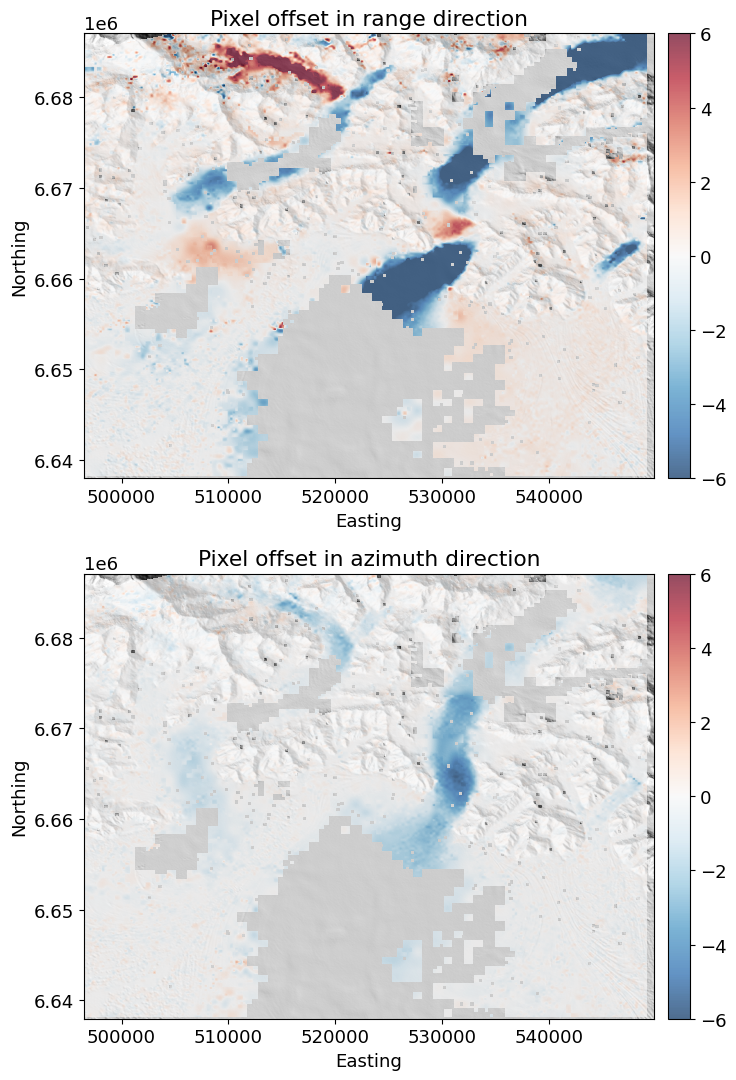

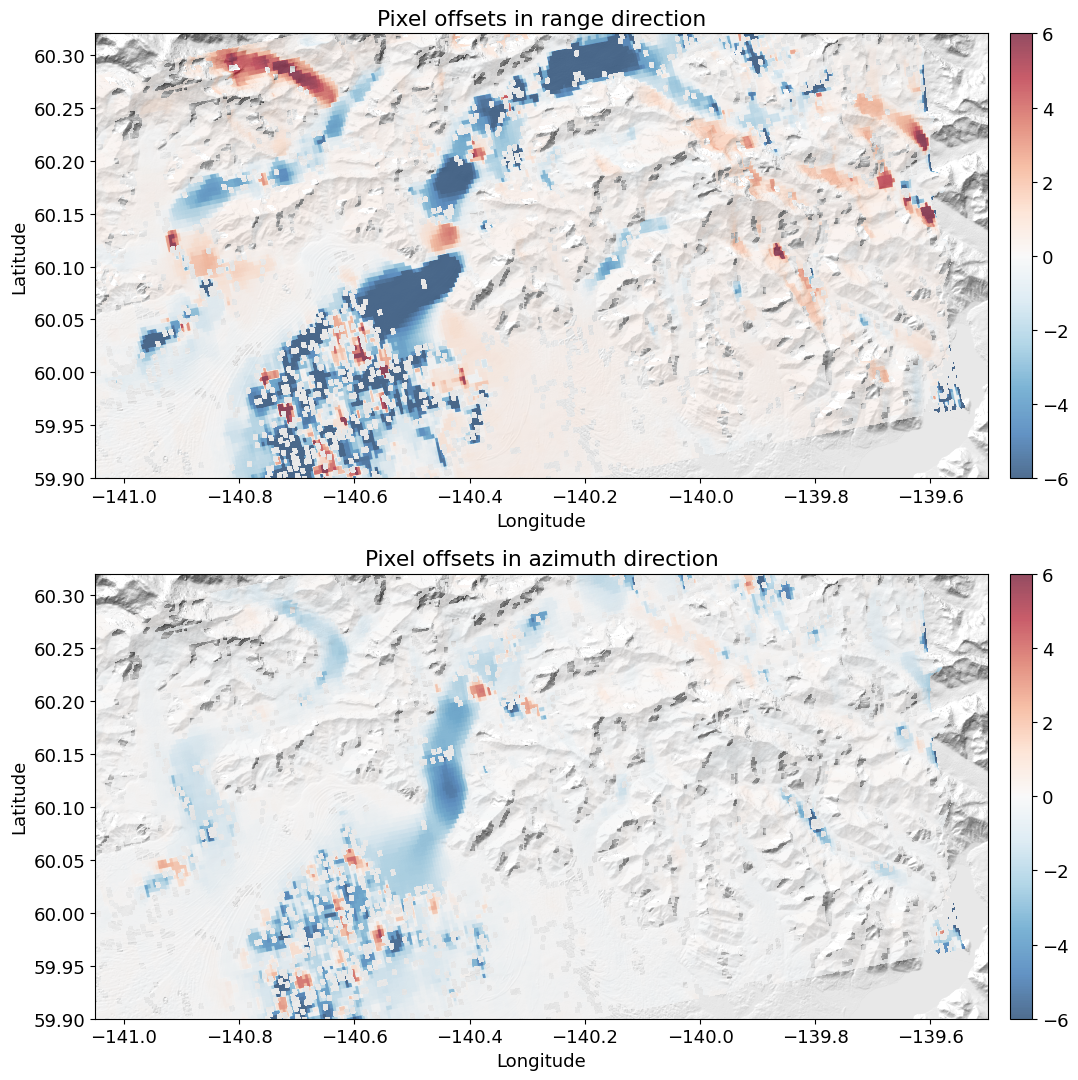

In [31]:
utils.plot_autorift_offsets(filename='offset.tif', vx_clim=(-6, 6), vy_clim=(-6, 6),
                            xtitle='Pixel offset in range direction',
                            ytitle='Pixel offset in azimuth direction')

# Let's also re-plot the ISCE dense offsets for comparision
utils.plot_offsets(results_dir='merged', xlim=(-141.05, -139.5), ylim=(59.9, 60.32), snr_thresh=2)

The second file, `velocity.tif`, contains the same offset information as `offset.tif`, but the offsets have been transformed to velocities by: 1) including the time separation between the reference and secondary images; and 2) projecting the offsets in the range and azimuth directions to East-West by assuming the flow is parallel to the surface slope as computed by the DEM. This is a common procedure for glacier and landscape studies when offset information from a single look direction is used.

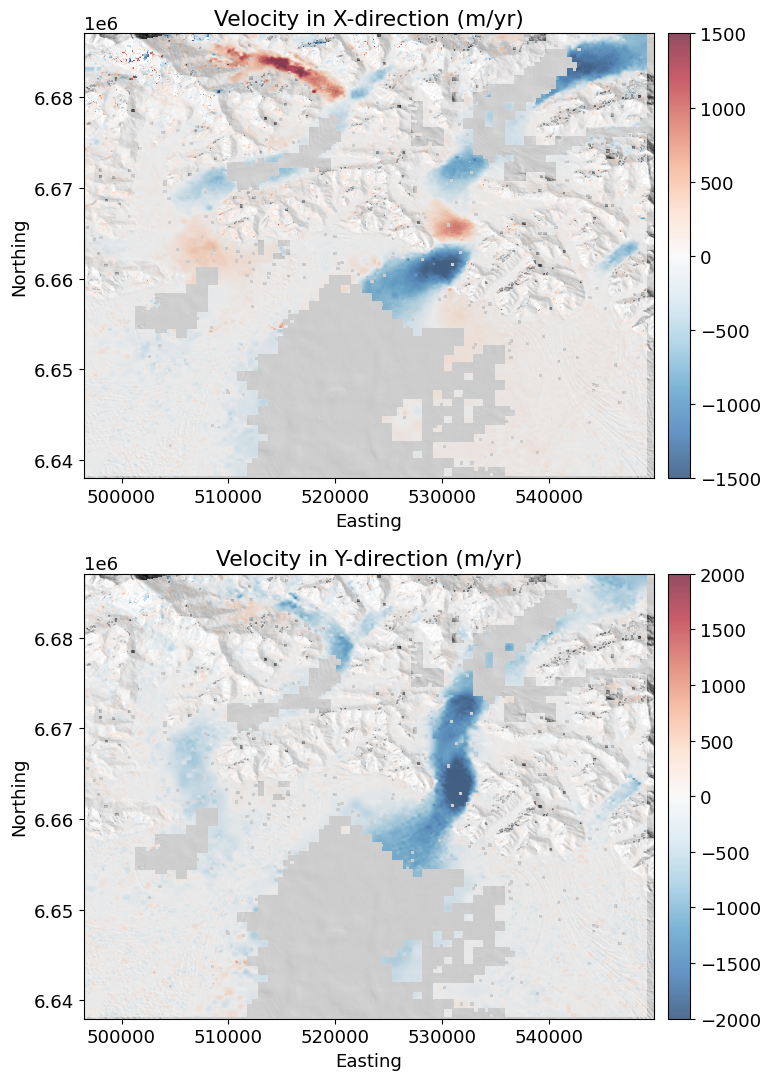

In [32]:
utils.plot_autorift_offsets(filename='velocity.tif', vx_clim=(-1500, 1500), vy_clim=(-2000, 2000))

Overall, we can see that the offset field generated by `autoRIFT` is fairly similar to the one generated by the ISCE/TOPS dense offsets module. `autoRIFT` tends to be more aggressive in masking out bad values, but the offsets in the high SNR areas look to be very similar between the two methods.

<br>
<div class="alert alert-danger">
<font size="4"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT</u>:  </font> Modify the dense offset parameters and re-run </b> </font>

Modify the window sizes for the `topsApp` dense offsets module by adjusting the window widths/heights and the search window widths/heights in the `topsApp.xml` file and re-running `topsApp.py --start=denseoffsets --end=geocodeoffsets`. For example, try reducing the windows by a factor of two. How does this affect the quality of the offset fields? How does this affect the runtime of the dense offset computation?</i></b>.

For plotting, you can place the files `filt_dense_offsets.bil.geo` and `dense_offsets_snr.bil.geo` for each new experiment in a new directory and pass that directory as `results_dir` to the function `utils.plot_offsets`.
</div>